In [183]:
# -.-|m { input: false, output: false }

# use this to export to html 
# jupyter nbconvert --to html --no-input  4_PAD_modelin.ipynb
# jupyter nbconvert 4_PAD_modelin.ipynb --to html --no-prompt --template myTPL/
## pretty jupyter template
# jupyter nbconvert --to html --template pj .\4_PAD_modelin.ipynb
%load_ext pretty_jupyter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt ,re
# from pandas_profiling import ProfileReport
from scipy.stats import ttest_ind

from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier,GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import chi2, f_classif, SelectKBest, mutual_info_classif, RFECV,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.svm import SVC, LinearSVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.model_selection import cross_validate,cross_val_score, RepeatedStratifiedKFold, StratifiedKFold

# from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from tableone import TableOne
from collections import defaultdict

The pretty_jupyter extension is already loaded. To reload it, use:
  %reload_ext pretty_jupyter


In [212]:
def plot_importance(series: pd.Series, title:str = "Feature Importance"):
    f, ax = plt.subplots(figsize=(5, 8))
    sns.set_color_codes("pastel")
    sns.barplot(x = series.values, y = series.index, color="r", ax=ax)
    ax.set_title(title)
    ax.axvline(x=series.mean(), label = "mean importance measure")
    plt.legend()
    plt.show()


def get_importance_cv(output_cv: dict, title: str = "Feature Importance", plot: bool = True):
    '''
    Finds the feature importance among cross-validated models using only the training data
    '''
    feature_importances = []
    for idx, pipeline in enumerate(output_cv['estimator']):
        estimator = pipeline['classifier']
        featImp = pd.Series(
            data = estimator.feature_importances_ if hasattr(
                estimator, 'feature_importances_') else np.abs(estimator.coef_.squeeze()),
            index = [re.search("^(.*?)__(.*?)$", x).group(2) for x in pipeline[:-1].get_feature_names_out()])
        feature_importances.append(featImp)

    xx = pd.concat(feature_importances, axis=0)
    xx = pd.DataFrame(xx, columns= ["Imp"])
    xx = xx.reset_index(names='name')
    # xx
    feat_order = xx.groupby('name')['Imp'].aggregate(np.mean).reset_index().sort_values('Imp', ascending=False)['name']
    if plot:
        sns.set_color_codes("pastel")
        f, ax = plt.subplots(figsize=(5, 8))
        sns.barplot(xx, x = 'Imp', y = 'name',
                    order= feat_order, color="r", ax=ax)
        ax.set_title(title)
        plt.show()
    return feat_order

def highlight(row):
    '''
    highlight the pandas tableone frames for significant variables
    '''
    # we have a multiple row index, and first one changes based on TARGET
    first_index = row.index[0][0]
    x = row.loc[(first_index, 'P-Value')].strip()
    if len(x)< 2:
        return ['background-color: None'] * len(row)
    elif x.startswith("<") or float(x) <= 0.05:
        return ['background-color: #E4A11B;'] * len(row)
    else:
        return ['background-color: None'] * len(row)

def get_sig_from_tableone(mytable) -> list:
    '''
    Extract significant predictors from tableone output.
    
    Note: pre-cleaning is needed and done because the p-values are strings
    '''
    idx = (mytable.tableone.columns[0][0], 'P-Value')
    xx = mytable.tableone[idx].str.lstrip("< ")
    xx = pd.to_numeric(xx).dropna()
    xx.index = mytable._columns
    signf_list = xx.loc[xx <= 0.05].index
    return signf_list

def pipeline_score(pipe, y_test, X_test, clf_name: str):
    y_pred_prob = pipe.predict_proba(X_test)[:,1]
    print(f"Test AUC Performance on {clf_name} = {metrics.roc_auc_score(y_test, y_pred_prob):.3f}")
    # print(f"Train AUC Performance on {clf_name} = {metrics.roc_auc_score(y_train, pipe.predict_proba(X_train)[:,1]):.3f}")

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    # get the best threshold - Youan's Index
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))

    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                    estimator_name=clf_name)
    f, ax = plt.subplots()
    display.plot(ax = ax)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
    ax.set_title(f'ROC curve ({clf_name})')
    plt.show()

def pipeline_score_all(pipes, y_test, X_test, plt_title:str = 'ROC curves'):
    all_results = []
    f, ax = plt.subplots()
    ax.set_title(f'ROC curves')
    ax.plot([0, 1], [0, 1], 'k--')
    for pipe in pipes:
        clf_name = type(pipe.named_steps['classifier']).__name__
        y_pred_prob = pipe.predict_proba(X_test)[:,1]
        
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
        # get the best threshold - Youan's Index
        J = tpr - fpr
        ix = np.argmax(J)
        best_thresh = thresholds[ix]

        y_pred = (y_pred_prob >= best_thresh).astype(int)
        results = {
            'model': clf_name,
            'AUROC': metrics.roc_auc_score(y_test, y_pred_prob),
            'prec': metrics.precision_score(y_test, y_pred),
            'recall': metrics.recall_score(y_test, y_pred),
            'F1': metrics.f1_score(y_test, y_pred),
            'thr': best_thresh
        }
        all_results.append(results)
        # plot auc
        roc_auc = metrics.auc(fpr, tpr)
        display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                    estimator_name=clf_name)
        display.plot(ax = ax)

    plt.show()
    return pd.DataFrame(all_results)
    
def score_train_test(pipe, X_train, X_test, y_train, y_test, plt_title:str = 'ROC curves'):
    '''final fit, train and test results'''
    all_results = []
    f, ax = plt.subplots()
    
    # model

    clf_name = type(pipe.named_steps['classifier']).__name__

    ax.set_title(f'ROC curves for {clf_name}')
    ax.plot([0, 1], [0, 1], 'k--')
    y_pred_prob = pipe.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    # get the best threshold - Youan's Index
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]

    y_pred = (y_pred_prob >= best_thresh).astype(int)
    test_results = {
        'model': clf_name +'_test',
        'AUROC': metrics.roc_auc_score(y_test, y_pred_prob),
        'prec': metrics.precision_score(y_test, y_pred),
        'recall': metrics.recall_score(y_test, y_pred),
        'F1': metrics.f1_score(y_test, y_pred),
        'accuracy': metrics.accuracy_score(y_test, y_pred),
        'cutoff': best_thresh
    }
    all_results.append(test_results)
    # plot auc
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                estimator_name='validation set')
    display.plot(ax = ax)
    #####
    #####
    #####
    y_pred_prob = pipe.predict_proba(X_train)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_prob)
    # get the best threshold - Youan's Index
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]

    y_pred = (y_pred_prob >= best_thresh).astype(int)
    train_results = {
        'model': clf_name + "_train",
        'AUROC': metrics.roc_auc_score(y_train, y_pred_prob),
        'prec': metrics.precision_score(y_train, y_pred),
        'recall': metrics.recall_score(y_train, y_pred),
        'F1': metrics.f1_score(y_train, y_pred),
        'accuracy': metrics.accuracy_score(y_train, y_pred),
        'cutoff': best_thresh
    }
    all_results.append(train_results)
    # plot auc
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                estimator_name='training set')
    disp = display.plot(ax = ax)
    return pd.DataFrame(all_results)

# Intro

This file is created after the initial modeling and cleaning step "3_PAD_MODELING" was done on the PAD study.

Here, I will go deeper in my approach to the exploratory data analysis and producing charts and plots about our predictors.

Also, the the modeling would be enhanced based on the feedbacks.

Here shows the first rows of data

In [3]:
pd.set_option('display.max_columns', 10)

df = pd.read_csv("./Data/processed_panel_1and3.csv")

PROTEINS = df.iloc[:,1:df.columns.get_loc("Age")].columns.to_list()
CLINICAL = ['Age', 'Gender', 'Hypertension', 'Hyperchol',
       'Diabetes', 'Renal Insufficiency', 'Smoking Hx',
       #  'Dialysis', # Zero variance
       'Congestive heart failure', 'Cornary artery disease', 'Stroke/TIA',
       'statin', 'ACEi/ARB', 'B-bl', 'CCB', 'HCTZ, Lasix', 'Insulin',
       # 'oral hypoglyc' # correlated with Diabetes
       ]

TARGET = ["hasPAD"]
df.head(10)

,ID,IL-33,uPAR,CXCL6,ESM-1,...,CCB,"HCTZ, Lasix",Insulin,oral hypoglyc,hasPAD
0,5,14.091162,557.896234,110.729424,1055.750683,...,0.0,0.0,0.0,NaN,0
1,14,33.331707,2383.453789,128.812424,472.920153,...,0.0,0.0,1.0,1.0,0
2,92,19.413896,922.174636,207.177434,983.060117,...,0.0,0.0,0.0,0.0,0
3,119,59.897453,2734.344683,645.989311,1323.804448,...,1.0,1.0,0.0,0.0,0
4,124,37.126933,4847.796709,268.216338,991.308486,...,0.0,0.0,0.0,1.0,0
5,125,22.044376,2206.218500,489.488196,673.253730,...,1.0,0.0,0.0,0.0,0
6,128,57.620453,2677.087531,380.001801,594.683007,...,1.0,0.0,0.0,0.0,0
7,133,10.027423,908.157598,199.410118,275.997849,...,0.0,0.0,0.0,0.0,0
8,209,22.699279,1145.192116,189.496576,195.253624,...,0.0,0.0,0.0,0.0,0
9,215,22.044376,950.177351,364.212070,619.267925,...,0.0,0.0,0.0,0.0,0


In [4]:
df.shape

(461, 65)

# Exploratory Analysis


## Proteins

Basic statistics from the proetins in panel

In [5]:
df.hasPAD.value_counts()

1    295
0    166
Name: hasPAD, dtype: int64

In [6]:
pd.set_option('display.colheader_justify', 'right')
df_viz = df.copy()
df_viz['hasPAD'] = df_viz['hasPAD'].map({0: 'Without PAD', 1: "With PAD"})

table1 = TableOne(df_viz, columns=PROTEINS,groupby=["hasPAD"], pval=True, htest_name=True, dip_test=True, tukey_test=True)

In [7]:
table1.tableone.style.apply(highlight, axis=1)

## Correlation analysis on proteins

- Now let's take a closer look at the proteins with significant (p-value < 0.05) difference among PAD and non-PAD patients.
- Below the most-correlated pairs are plotted

In [8]:
numerical_sig = ['uPAR', 'SCF', 'TSG-14', 'RAGE', 'ADAMTS13', 'Tpo', 'TNF RII', 'TNF RI',
       'ANGPTL3', 'ANGPTL4', 'CD40', 'CXCL1', 'NT- pro BNP', 'Troponin I',
       'ANGPTL6', 'Alpha 1-Microglobulin', 'Galectin-9', 'PBEF/Visfatin',
       'Cathepsin S', 'APRIL/TNFSF13', 'Galectin-1', 'ALCAM/CD166', 'GDF-15',
       'Chemerin', 'Endostatin', 'Age']

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations:")
print(get_top_abs_correlations(df[numerical_sig], 10))

Top Absolute Correlations:
TNF RI       CD40          0.896011
TNF RII      TNF RI        0.868427
             CD40          0.800065
NT- pro BNP  Troponin I    0.776937
RAGE         TNF RI        0.746230
SCF          TNF RI        0.739789
RAGE         CD40          0.716821
             TNF RII       0.679507
SCF          TNF RII       0.650906
Galectin-9   Galectin-1    0.638577
dtype: float64


Removing **('TNF RII',  "CD40",'NT- pro BNP')** from the list of proteins and print the top correlated pairs again.

In [9]:
print(get_top_abs_correlations(df[[x for x in numerical_sig if x not in ('TNF RII',  "CD40",'NT- pro BNP')]], 10))

RAGE         TNF RI         0.746230
SCF          TNF RI         0.739789
Galectin-9   Galectin-1     0.638577
TNF RI       ANGPTL4        0.633273
SCF          RAGE           0.616710
Galectin-9   Endostatin     0.571809
Cathepsin S  ALCAM/CD166    0.554160
uPAR         TNF RI         0.548759
Galectin-1   ALCAM/CD166    0.548414
Cathepsin S  Galectin-1     0.540669
dtype: float64


> Expert opinion could help with the selection of proteins to remove due to high correlation.

The number of missing values could also affect this decision.

In [10]:
df[["TNF RI", "RAGE", "SCF", "NT- pro BNP", "Troponin I"]].isna().sum().to_frame().rename(columns = {0:"# of missing"})

,# of missing
TNF RI,0
RAGE,7
SCF,15
NT- pro BNP,35
Troponin I,35


## Clinical Variables


In [11]:
CLINICAL = ['Age', 'Gender', 'Hypertension', 'Hyperchol',
       'Diabetes', 'Renal Insufficiency', 'Smoking Hx',
       #  'Dialysis', # Zero variance
       'Congestive heart failure', 'Cornary artery disease', 'Stroke/TIA',
       'statin', 'ACEi/ARB', 'B-bl', 'CCB', 'HCTZ, Lasix', 'Insulin',
       # 'oral hypoglyc' # correlated with Diabetes
       ]

table_args = {
       'categorical': CLINICAL[1:],
       'groupby': ["hasPAD"],
       'pval': True,
       'htest_name': True
}

table_c = TableOne(df_viz, CLINICAL, **table_args)

In [12]:
table_c.tableone.style.apply(highlight, axis=1)

In [156]:
# final subset of significant variables -- based on univariate test --

final_clinical = [
    'Hypertension',
    'Hyperchol',
    'Diabetes',
    'Renal Insufficiency',
    'Smoking Hx',
    'Congestive heart failure',
    'Cornary artery disease',
    'Stroke/TIA',
    'B-bl',
    # 'statin', #removed due to possible data leakage
    # 'ACEi/ARB',
    # 'CCB'
]
print("final subset of significant clinical variables -- based on univariate test --\n", final_clinical)

final subset of significant clinical variables -- based on univariate test --
 ['Hypertension', 'Hyperchol', 'Diabetes', 'Renal Insufficiency', 'Smoking Hx', 'Congestive heart failure', 'Cornary artery disease', 'Stroke/TIA', 'B-bl']


# Predictive Modeling

## Preprocessing and Pipeline creation

Here change add/remove any feature

In [130]:
numerical_final = [x for x in numerical_sig if x not in ('TNF RII',  'CD40','NT- pro BNP')]
numerical_final.append('Age') if 'Age' not in numerical_final else None
binary_final = [x for x in final_clinical if x not in ('Smoking Hx')]
cat_final = ['Smoking Hx']

The only categorical predictor with more than 2 levels is **Smoking**.

In [131]:
# only non-binary categorical -->
df["Smoking Hx"].value_counts(dropna=False).to_frame().rename_axis("Values",axis=0)

,Smoking Hx
Values,
1.0,237
0.0,124
2.0,95
NaN,5


In [132]:
# contstructing the preprocessing piplines - same as 3_pad_modeling.ipynb

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)

binary_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"))

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("onehot", OneHotEncoder(drop=None))]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("continous", numeric_transformer, numerical_final),
        ("binary", binary_transformer, binary_final),
        ("categorical", categorical_transformer, cat_final)
    ]
)

## Model 1: Logistic Regression

In [133]:
newX = df[numerical_final + binary_final + cat_final].copy()

y = df[TARGET].to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(
    newX, y, stratify= y,
     train_size=0.7, random_state=42)

myModel = LogisticRegression(penalty= "l1", solver= 'liblinear',random_state= 42)

model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', myModel)
])


In [134]:
%%jmd

Patients in our study are splitted into a train and test cohort (70-30). All model training and tuning of the parameters is done on the training set.
The test set is remained un-seen by the model, until when the final predition is made.

* Train set contains {{X_train.shape[0]}} ({{y_train.sum()}} are PAD patients)
* Test set contains {{X_test.shape[0]}} ({{y_test.sum()}} are PAD patients)


Patients in our study are splitted into a train and test cohort (70-30). All model training and tuning of the parameters is done on the training set.
The test set is remained un-seen by the model, until when the final predition is made.

* Train set contains 322 (206 are PAD patients)
* Test set contains 139 (89 are PAD patients)

In [135]:
output = cross_validate(model_pipe, X_train,
                        y_train, scoring=['roc_auc', 'precision', 'recall'],
                        cv=StratifiedKFold(5),
                        return_estimator=True,
                        return_train_score=True)
print(f"cross-validation accuracy: AUC = {output['test_roc_auc'].mean():.2f} (std {output['test_roc_auc'].std():.2f})")

cross-validation accuracy: AUC = 0.80 (std 0.05)


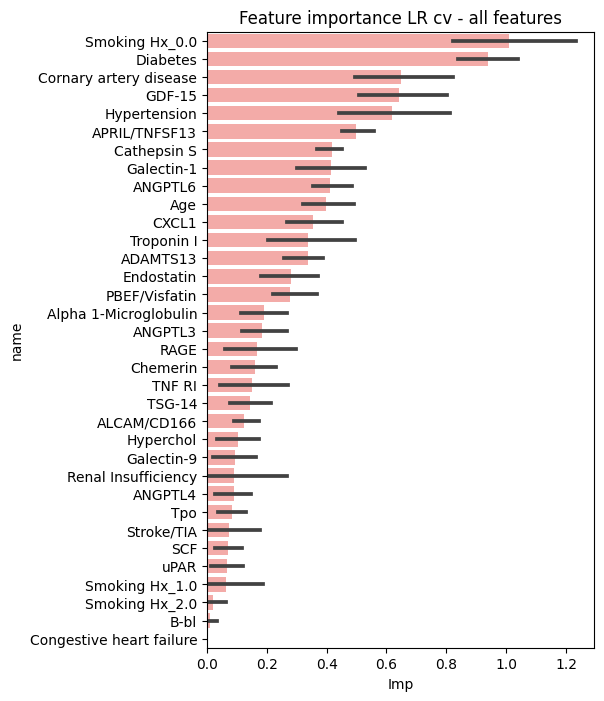

In [123]:
feat_imp_lr = get_importance_cv(output, "Feature importance LR cv - all features")

### Tuning model with Feature selection

In [55]:
# res = []
# num_features = range(4,22,2)
# for n in num_features:
#     topn = xx[:n].index.tolist()
#     numerical_final = [x for x in numerical_sig if x not in ('TNF RII',  'CD40','NT- pro BNP')]
#     numerical_final.append('Age') if 'Age' not in numerical_final else None
#     binary_final = [x for x in final_clinical if x not in ('Smoking Hx')]
#     cat_final = ['Smoking Hx']


#     numerical_final = [x for x in numerical_final if x in topn]
#     numerical_final.append('Age') if 'Age' not in numerical_final else None
#     binary_final = [x for x in binary_final if x in topn]

#     preprocessor = ColumnTransformer(
#         transformers=[
#             ("continous", numeric_transformer, numerical_final),
#             ("binary", binary_transformer, binary_final),
#             ("categorical", categorical_transformer, cat_final)
#         ]
#     )
#     newX = df[numerical_final + binary_final + cat_final].copy()

#     y = df[TARGET].to_numpy().ravel()

#     X_train, X_test, y_train, y_test = train_test_split(
#         newX, y, stratify= y,
#         train_size=0.7, random_state=42)

#     myModel = LogisticRegressionCV(penalty="l1", solver='liblinear',
#                                 cv=StratifiedKFold(5),
#                                 scoring='roc_auc',
#                                 # class_weight = 'balanced',
#                                 random_state=42)
#     model_pipe = Pipeline([
#         ("preprocessing", preprocessor),
#         ('classifier', myModel)
#     ])

#     model_pipe.fit(X_train, y_train)
#     # print(newX.shape)
#     res.append(model_pipe)
# results = pipeline_score_all(res, y_test, X_test)
# results["top features used"] = num_features
# results

In [147]:
numerical_final = [x for x in numerical_sig if x not in ('TNF RII',  'CD40','NT- pro BNP')]
numerical_final.append('Age') if 'Age' not in numerical_final else None
binary_final = [x for x in final_clinical if x not in ('Smoking Hx')]
cat_final = ['Smoking Hx']


preprocessor = ColumnTransformer(
    transformers=[
        # ("continous", numeric_transformer, numerical_final),
        ("binary", binary_transformer, binary_final),
        ("categorical", categorical_transformer, cat_final)
    ]
)
newX = df[ binary_final + cat_final].copy()

y = df[TARGET].to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(
    newX, y, stratify= y,
    train_size=0.7, random_state=42)

myModel = LogisticRegressionCV(penalty="l1", solver='liblinear',
                            cv=StratifiedKFold(5),
                            scoring='roc_auc',
                            # class_weight = 'balanced',
                            random_state=42)
model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', myModel)
])

output = cross_validate(model_pipe, X_train,
                        y_train, scoring=['roc_auc', 'precision', 'recall'],
                        cv=StratifiedKFold(5),
                        return_estimator=True,
                        return_train_score=True)
print(f"cross-validation accuracy - only clinical features: AUC = {output['test_roc_auc'].mean():.2f} (std {output['test_roc_auc'].std():.2f})")

cross-validation accuracy - only clinical features: AUC = 0.74 (std 0.05)


> Training the model solely on Clinical variables -- no protein predictor used, results in AUC of 0.79

In [148]:
feat_imp_lr = get_importance_cv(output, "Feature importance LR cv -  only clinical", plot=False)
feat_imp_lr

7               Smoking Hx_0.0
3                     Diabetes
5                 Hypertension
6          Renal Insufficiency
1     Congestive heart failure
10                  Stroke/TIA
2       Cornary artery disease
4                    Hyperchol
9               Smoking Hx_2.0
0                         B-bl
8               Smoking Hx_1.0
Name: name, dtype: object

### Final Logistic Regression Model

THis model is trained on the top performing clinical variables and proteins `GDF-15`, `APRIL/TNFSF13`, `Cathepsin S`, `Galectin-1`, `ANGPTL6`

__List of features used:__ ['Diabetes', 'Smoking Hx', 'Hypertension', 'Congestive heart failure', 'Renal Insufficiency', 'Stroke/TIA',
        'GDF-15', 'APRIL/TNFSF13', 'Cathepsin S', 'Galectin-1', 'ANGPTL6', 'Age']

In [167]:
topn = ['Diabetes', 'Smoking Hx', 'Hypertension', 'Congestive heart failure', 'Renal Insufficiency', 'Stroke/TIA',
        'GDF-15', 'APRIL/TNFSF13', 'Cathepsin S', 'Galectin-1', 'ANGPTL6', 'Age']

##################################
numerical_final = [x for x in numerical_sig if x not in ('TNF RII',  'CD40','NT- pro BNP')]
numerical_final.append('Age') if 'Age' not in numerical_final else None
binary_final = [x for x in final_clinical if x not in ('Smoking Hx')]
cat_final = ['Smoking Hx']


numerical_final = [x for x in numerical_final if x in topn]
# numerical_final.append('Age') if 'Age' not in numerical_final else None
binary_final = [x for x in binary_final if x in topn]

preprocessor = ColumnTransformer(
    transformers=[
        ("continous", numeric_transformer, numerical_final),
        ("binary", binary_transformer, binary_final),
        ("categorical", categorical_transformer, cat_final)
    ]
)
newX = df[topn].copy()

y = df[TARGET].to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(
    newX, y, stratify= y,
    train_size=0.7, random_state=42)

myModel = LogisticRegressionCV(penalty="l1", solver='liblinear',
                            cv=StratifiedKFold(5),
                            scoring='roc_auc',
                            # class_weight = 'balanced',
                            random_state=42)
top_clinic_protein = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', myModel)
])

output = cross_validate(top_clinic_protein, X_train,
                        y_train, scoring=['roc_auc', 'accuracy','precision', 'recall'],
                        cv=StratifiedKFold(5),
                        return_estimator=True,
                        return_train_score=True)

print(f"cross-validation accuracy: AUC = {output['test_roc_auc'].mean():.2f} (std {output['test_roc_auc'].std():.2f})")

cross-validation accuracy: AUC = 0.79 (std 0.05)


In [232]:
# Cross-validation results
final_cv_output = defaultdict(pd.DataFrame)
final_result_tables = defaultdict(pd.DataFrame)
final_result_figs = defaultdict()
final_cv_output['LR'] = pd.DataFrame(output)[[
                     'train_roc_auc', 'train_accuracy','train_precision', 'train_recall',
                       'test_roc_auc', 'test_accuracy','test_precision', 'test_recall']].agg([np.mean, np.std], axis=0)


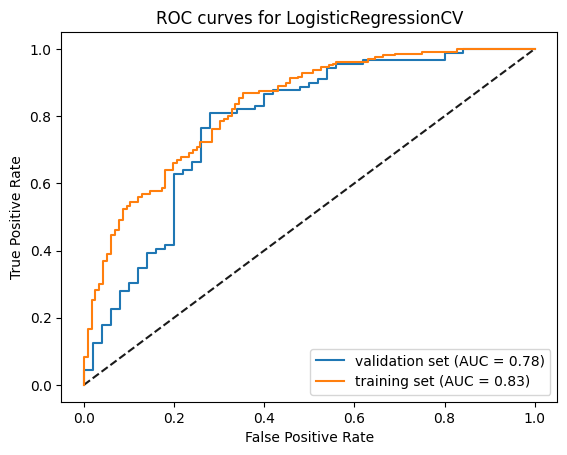

In [233]:
top_clinic_protein.fit(X_train, y_train)
# pipeline_score_all([model_pipe], y_test, X_test, "LR ROC on ")
res = score_train_test(top_clinic_protein, X_train, X_test, y_train, y_test)
final_result_tables['LR'] = res

## Model 2: Random Forest

In [234]:
## setting to use all features at start
numerical_final = [x for x in numerical_sig if x not in ('TNF RII',  'CD40','NT- pro BNP')]
numerical_final.append('Age') if 'Age' not in numerical_final else None
binary_final = [x for x in final_clinical if x not in ('Smoking Hx')]
cat_final = ['Smoking Hx']

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)

binary_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"))

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("onehot", OneHotEncoder(drop=None))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("continous", numeric_transformer, numerical_final),
        ("binary", binary_transformer, binary_final),
        ("categorical", categorical_transformer, cat_final)
    ]
    
)
newX = df[numerical_final + binary_final + cat_final].copy()

y = df[TARGET].to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(
    newX, y, stratify= y,
     train_size=0.7, random_state=42)


In [235]:
mod_rf = RandomForestClassifier(n_estimators=100, min_samples_split=2, random_state=42)

model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', mod_rf)
])

# model_pipe.fit(X_train, y_train)

param_grid = {
    'classifier__n_estimators': [10, 20, 50, 100, 200, 300],
    'classifier__max_features': [None, 'sqrt', 'log2', 0.3, 0.4, 0.5],
    'classifier__min_samples_split': [2,4,8,16,32]
}

search = GridSearchCV(model_pipe,
                      param_grid,
                      cv=StratifiedKFold(5),
                      n_jobs=-1,
                      scoring="roc_auc",
                      return_train_score=True)
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# test
# pipeline_score(model_pipe, y_test, X_test, "Random Forest")


Best parameter (CV score=0.752):
{'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 8, 'classifier__n_estimators': 300}


In [236]:
# now training the rf model on tuned params and look at 
tuned_params = search.best_estimator_['classifier'].get_params()
mod_rf = RandomForestClassifier(**tuned_params)

rf_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', mod_rf)
])

rf_pipe.fit(X_train, y_train)
# pipeline_score(rf_pipe, y_test, X_test, "Random Forest")
output = cross_validate(rf_pipe, X_train,
                        y_train, scoring=['roc_auc', 'precision', 'recall'],
                        cv=StratifiedKFold(5),
                        return_estimator=True,
                        return_train_score=True)


> Warning Impurity-based feature importances can be misleading for high cardinality features (many unique values). Therefore our numerical features are shown to be in the top-performing features, whereas, definately clinical features are important as shown in Logisitc Regression

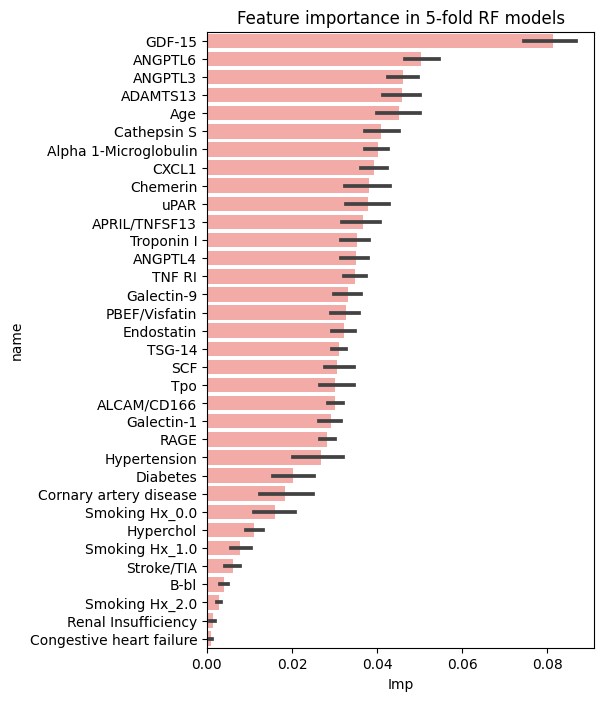

In [237]:
features = get_importance_cv(output, title = "Feature importance in 5-fold RF models")

Using the top 10 features, that are all proteins, and the clinical variables (as they proved to be important before) the random forest model is retrained and

In [252]:
# now let's use the top features and re-train/tune the RF model again
topn = features.iloc[:10].tolist()

##################################
# intitalize based on signficiant tests
numerical_final = [x for x in numerical_sig if x not in ('TNF RII',  'CD40','NT- pro BNP')]
numerical_final.append('Age') if 'Age' not in numerical_final else None
binary_final = [x for x in final_clinical if x not in ('Smoking Hx')]
cat_final = ['Smoking Hx']

# filter based on top features selected before
numerical_final = [x for x in numerical_final if x in topn]

# binary_final = [x for x in binary_final if x in topn]
# cat_final = [x for x in cat_final if x in topn]

preprocessor = ColumnTransformer(
    transformers=[
        ("continous", numeric_transformer, numerical_final),
        ("binary", binary_transformer, binary_final),
        ("categorical", categorical_transformer, cat_final)
    ]
)
newX = df[numerical_final + binary_final + cat_final].copy()

y = df[TARGET].to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(
    newX, y, stratify= y,
    train_size=0.7, random_state=42)

mod_rf = RandomForestClassifier(n_estimators=100, min_samples_split=2)

model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', mod_rf)
])

# model_pipe.fit(X_train, y_train)

param_grid = {
    'classifier__n_estimators': [10, 20, 50, 100, 200, 300],
    'classifier__max_features': [None, 'sqrt', 'log2', 0.3, 0.4, 0.5],
    'classifier__min_samples_split': [2,4,8,16,32]
}

search = GridSearchCV(model_pipe,
                      param_grid,
                      cv=StratifiedKFold(5, shuffle=True, random_state=42),
                      n_jobs=-1,
                      scoring="roc_auc",
                      return_train_score=True)
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


# now training the rf model on tuned params and look at 
# tuned_params = search.best_estimator_['classifier'].get_params()
# mod_rf = RandomForestClassifier(**tuned_params)

rf_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', search.best_estimator_['classifier'])
])

output = cross_validate(rf_pipe, X_train,
                        y_train, scoring=['roc_auc', 'accuracy','precision', 'recall'],
                        cv=StratifiedKFold(5, random_state=42, shuffle=True),
                        return_estimator=True,
                        return_train_score=True)

rf_pipe.fit(X_train, y_train)

Best parameter (CV score=0.764):
{'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 16, 'classifier__n_estimators': 200}


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('continous',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['uPAR', 'ADAMTS13',
                                                   'ANGPTL3', 'CXCL1',
                                                   'ANGPTL6',
                                                   'Alpha 1-Microglobulin',
                                                   'Cathepsin S', 'GDF-15',
                                                   'Chemerin', 'Age']),
                                                 ('binary',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='mos...equent'))]),
                                                  ['Hypertension', 'Hyperchol',
                                                   'Diabetes',
                                                   'Renal Insufficiency',
                                                   'Congestive heart failure',
                                                   'Cornary artery disease',
                                                   'Stroke/TIA', 'B-bl']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Smoking Hx'])])),
                ('classifier',
                 RandomForestClassifier(min_samples_split=16,
                                        n_estimators=200))])

In [256]:
output = cross_validate(rf_pipe, X_train,
                        y_train, scoring=['roc_auc', 'accuracy','precision', 'recall'],
                        cv=StratifiedKFold(5, random_state=42, shuffle=True),
                        return_estimator=True,
                        return_train_score=True)

pd.DataFrame(output).agg([np.mean, np.std], axis=0)


C:\Users\MacREAL3\AppData\Local\Temp\ipykernel_23280\3852504191.py:7: FutureWarning: ['estimator'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  pd.DataFrame(output).agg([np.mean, np.std], axis=0)


,fit_time,score_time,test_roc_auc,train_roc_auc,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall
mean,0.466331,0.079758,0.749746,0.989428,0.711250,0.931680,0.730720,0.906192,0.869222,0.996364
std,0.157839,0.031488,0.068728,0.002866,0.040954,0.003383,0.023109,0.003547,0.046017,0.003320


In [242]:
X_train.columns

Index(['uPAR', 'ADAMTS13', 'ANGPTL3', 'CXCL1', 'ANGPTL6',
       'Alpha 1-Microglobulin', 'Cathepsin S', 'GDF-15', 'Chemerin', 'Age',
       'Hypertension', 'Hyperchol', 'Diabetes', 'Renal Insufficiency',
       'Congestive heart failure', 'Cornary artery disease', 'Stroke/TIA',
       'B-bl', 'Smoking Hx'],
      dtype='object')

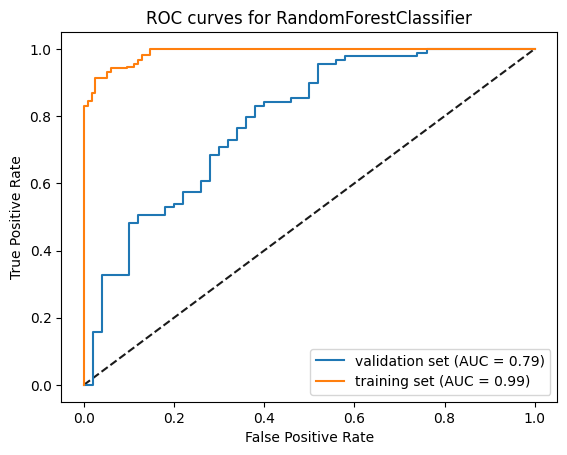

In [257]:
final_cv_output['RF'] = pd.DataFrame(output)[[
                     'train_roc_auc', 'train_accuracy','train_precision', 'train_recall',
                       'test_roc_auc', 'test_accuracy','test_precision', 'test_recall']].agg([np.mean, np.std], axis=0)

rf_pipe.fit(X_train, y_train)
res = score_train_test(rf_pipe, X_train, X_test, y_train, y_test)
final_result_tables['RF'] = res

This feature importance is just for reference, when all models are trained, all feature importances on the main training set are computed and compared.

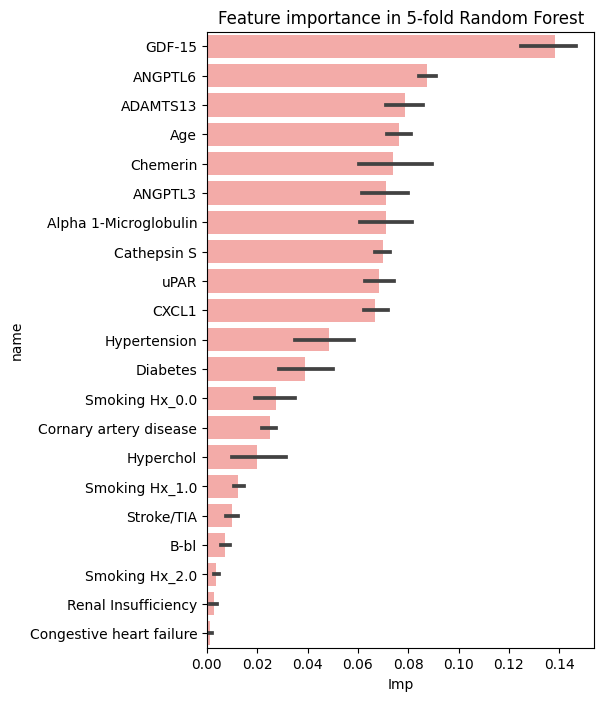

In [259]:
features = get_importance_cv(output, title = "Feature importance in 5-fold Random Forest")

## Model 3: Support Vector Machines

In [260]:
## setting to use all features at start
numerical_final = [x for x in numerical_sig if x not in ('TNF RII',  'CD40','NT- pro BNP')]
numerical_final.append('Age') if 'Age' not in numerical_final else None
binary_final = [x for x in final_clinical if x not in ('Smoking Hx')]
cat_final = ['Smoking Hx']

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)

binary_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"))

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("onehot", OneHotEncoder(drop=None))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("continous", numeric_transformer, numerical_final),
        ("binary", binary_transformer, binary_final),
        ("categorical", categorical_transformer, cat_final)
    ]
    
)
newX = df[numerical_final + binary_final + cat_final].copy()

y = df[TARGET].to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(
    newX, y, stratify= y,
     train_size=0.7, random_state=42)

clf = SVC(kernel='linear', gamma='auto')

model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', clf)
])

output = cross_validate(model_pipe, X_train,
                        y_train, scoring=['roc_auc', 'precision', 'recall'],
                        cv=StratifiedKFold(5, random_state=42, shuffle=True),
                        return_estimator=True,
                        return_train_score=True)

print(f"cross-validation accuracy: AUC = {output['test_roc_auc'].mean():.2f} (std {output['test_roc_auc'].std():.2f})")

cross-validation accuracy: AUC = 0.77 (std 0.05)


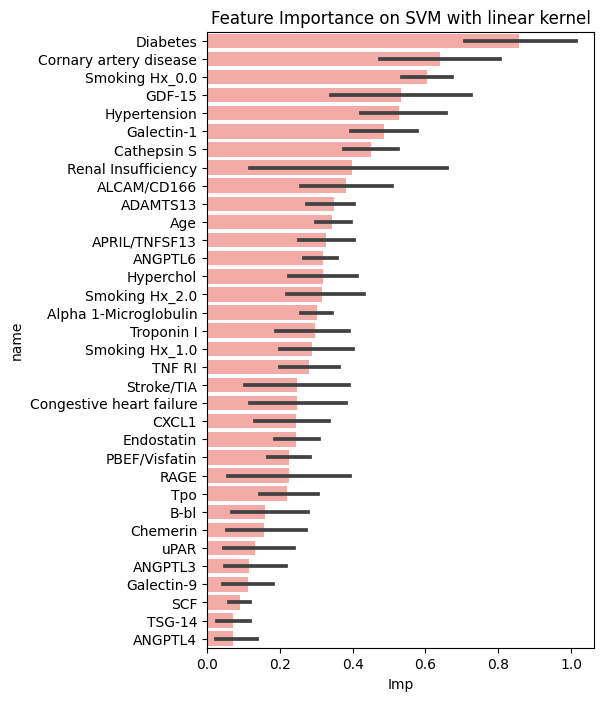

In [262]:
feat_imp = get_importance_cv(output, title = "Feature Importance on SVM with linear kernel")

In [268]:
%%jmd
Using the top 15 features:
* {{feat_imp.iloc[:12].tolist()}}

Using the top 15 features:
* ['Diabetes', 'Cornary artery disease', 'Smoking Hx_0.0', 'GDF-15', 'Hypertension', 'Galectin-1', 'Cathepsin S', 'Renal Insufficiency', 'ALCAM/CD166', 'ADAMTS13', 'Age', 'APRIL/TNFSF13']

In [269]:
topn = feat_imp.iloc[:15].tolist()

##################################
# intitalize based on signficiant tests
numerical_final = [x for x in numerical_sig if x not in ('TNF RII',  'CD40','NT- pro BNP')]
numerical_final.append('Age') if 'Age' not in numerical_final else None
binary_final = [x for x in final_clinical if x not in ('Smoking Hx')]
cat_final = ['Smoking Hx']

# filter based on top features selected before
numerical_final = [x for x in numerical_final if x in topn]
binary_final = [x for x in binary_final if x in topn]
# cat_final = [x for x in cat_final if x in topn]

preprocessor = ColumnTransformer(
    transformers=[
        ("continous", numeric_transformer, numerical_final),
        ("binary", binary_transformer, binary_final),
        ("categorical", categorical_transformer, cat_final)
    ]
)
newX = df[numerical_final + binary_final + cat_final].copy()

y = df[TARGET].to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(
    newX, y, stratify= y,
    train_size=0.7, random_state=42)


# user linear kernel, as rbf doesn't allow feature importance easily
model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', clf)
])

param_grid = {
    'classifier__C': [1e-3, 1e-2, 1e-1, 0.5, 1, 10],
}

search = GridSearchCV(model_pipe,
                      param_grid,
                      cv=StratifiedKFold(5),
                      n_jobs=-1,
                      scoring="roc_auc",
                      return_train_score=True)
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


Best parameter (CV score=0.816):
{'classifier__C': 0.1}


In [272]:
svm_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', search.best_estimator_['classifier'])
])

output = cross_validate(model_pipe, X_train,
                        y_train, scoring=['roc_auc', 'accuracy','precision', 'recall'],
                        cv=StratifiedKFold(5, random_state=42, shuffle=True),
                        return_estimator=True,
                        return_train_score=True)

print(f"cross-validation accuracy: AUC = {output['test_roc_auc'].mean():.2f} (std {output['test_roc_auc'].std():.2f})")

cross-validation accuracy: AUC = 0.79 (std 0.04)


In [276]:
final_cv_output['SVM'] = pd.DataFrame(output)[[
                     'train_roc_auc', 'train_accuracy','train_precision', 'train_recall',
                       'test_roc_auc', 'test_accuracy','test_precision', 'test_recall']].agg([np.mean, np.std], axis=0)

svm_pipe.fit(X_train, y_train)

'SVC'

,model,AUROC,prec,recall,F1,accuracy,cutoff
0,SVC_test,0.770787,0.813187,0.831461,0.822222,0.769784,0.232948
1,SVC_train,0.832734,0.867052,0.728155,0.791557,0.754658,0.704028


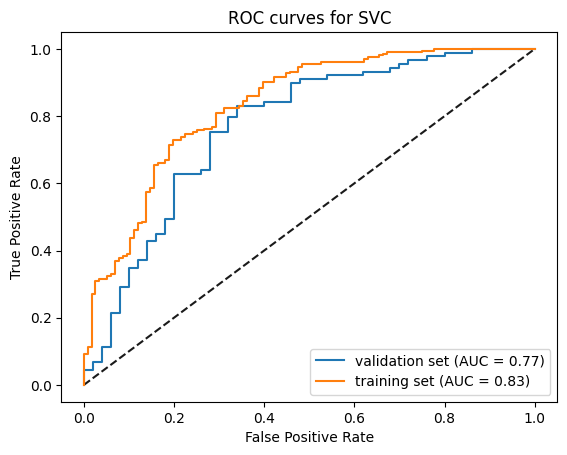

In [281]:
all_results = []
f, ax = plt.subplots()
# model
clf_name = type(svm_pipe.named_steps['classifier']).__name__

ax.set_title(f'ROC curves for {clf_name}')
ax.plot([0, 1], [0, 1], 'k--')
y_pred_prob = svm_pipe.decision_function(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
# get the best threshold - Youan's Index
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

y_pred = (y_pred_prob >= best_thresh).astype(int)
test_results = {
    'model': clf_name +'_test',
    'AUROC': metrics.roc_auc_score(y_test, y_pred_prob),
    'prec': metrics.precision_score(y_test, y_pred),
    'recall': metrics.recall_score(y_test, y_pred),
    'F1': metrics.f1_score(y_test, y_pred),
    'accuracy': metrics.accuracy_score(y_test, y_pred),
    'cutoff': best_thresh
}
all_results.append(test_results)
# plot auc
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                            estimator_name='validation set')
display.plot(ax = ax)
#####
#####
#####
y_pred_prob = svm_pipe.decision_function(X_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_prob)
# get the best threshold - Youan's Index
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

y_pred = (y_pred_prob >= best_thresh).astype(int)
train_results = {
    'model': clf_name + "_train",
    'AUROC': metrics.roc_auc_score(y_train, y_pred_prob),
    'prec': metrics.precision_score(y_train, y_pred),
    'recall': metrics.recall_score(y_train, y_pred),
    'F1': metrics.f1_score(y_train, y_pred),
    'accuracy': metrics.accuracy_score(y_train, y_pred),
    'cutoff': best_thresh
}
all_results.append(train_results)
# plot auc
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                            estimator_name='training set')
disp = display.plot(ax = ax)

############################
final_result_tables["SVM"] =  pd.DataFrame(all_results)
final_result_tables["SVM"]

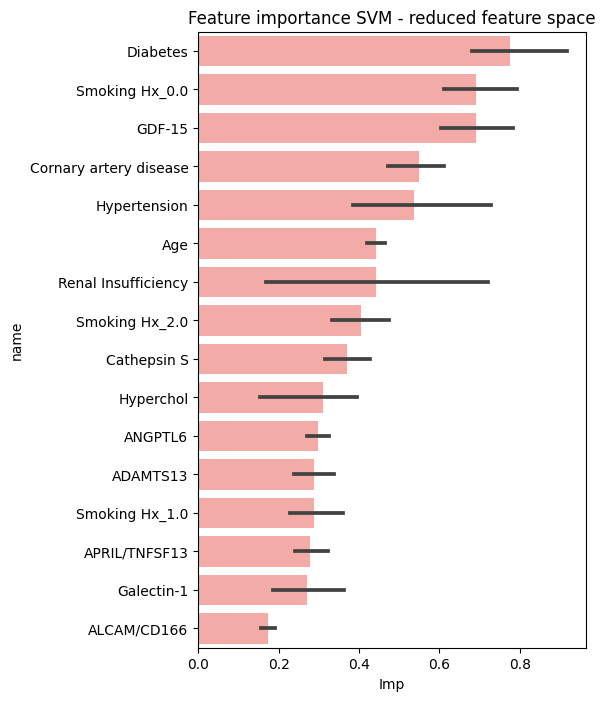

In [282]:
feat_imp_svm = get_importance_cv(output, "Feature importance SVM - reduced feature space")

## Model 4: GBM 

Using the famous XGBOOST or gradient boosted trees

In [65]:
param_grid_1 = {
    # 'loss': ['log_loss', 'exponential'],
    'max_depth': range(3,10),
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2],
    'subsample': [0.7, 0.8, 0.9, 1] #stochastic gradient boosting
}
param_grid = {f"classifier__{k}":v for k,v in param_grid_1.items()}

clf = GradientBoostingClassifier(loss='log_loss', random_state=42 )
model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', clf)
])

search = RandomizedSearchCV(model_pipe, param_grid, cv= StratifiedKFold(5), n_iter = 100, scoring="roc_auc", random_state=42, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.759):
{'classifier__subsample': 0.8, 'classifier__n_estimators': 200, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.01}


In [67]:
tuned_params_1 = search.best_estimator_['classifier'].get_params()
clf = GradientBoostingClassifier(**tuned_params_1)

param_grid_2 = {
    'max_features' : [None, 'sqrt', 'log2', 0.3, 0.4, 0.5, 0.6],
    'min_samples_split': [2,4,8,16,32,64],
    "min_samples_leaf": [1, 2, 5, 10, 20, 50, 100],
    'criterion': ['friedman_mse', 'squared_error'],
    
}
param_grid = {f"classifier__{k}":v for k,v in param_grid_2.items()}

model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', clf)
])

search = RandomizedSearchCV(model_pipe, param_grid, cv= StratifiedKFold(5), n_iter = 100, scoring="roc_auc", random_state=42, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.761):
{'classifier__min_samples_split': 16, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 0.6, 'classifier__criterion': 'friedman_mse'}


In [69]:
tuned_params_2 = search.best_estimator_['classifier'].get_params()
clf = GradientBoostingClassifier(**tuned_params_2)

param_grid = {
    'classifier__ccp_alpha': np.linspace(0, 0.01, 50)
}

model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', clf)
])

search = GridSearchCV(model_pipe, param_grid, cv= StratifiedKFold(5), n_jobs=-1, scoring="roc_auc", return_train_score=True)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.761):
{'classifier__ccp_alpha': 0.004693877551020408}


### Final Tuned GBM results


Test AUC Performance on GBM = 0.805
Train AUC Performance on GBM = 0.966
Best Threshold=0.582107


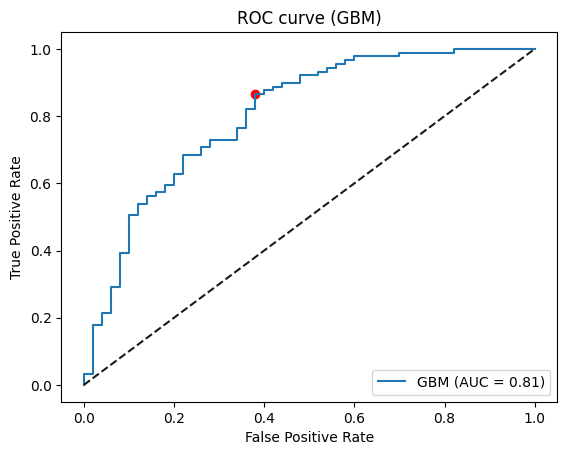

In [72]:
final_tuned = search.best_estimator_['classifier'].get_params()
clf = GradientBoostingClassifier(**final_tuned)
gbm_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', clf)
])

gbm_pipe.fit(X_train, y_train)
pipeline_score(gbm_pipe, y_test, X_test, "GBM")

# Results

Here I will summarize the results for all 3 trained models.

- The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. `precision = tp / (tp + fp)`
    + It is specifically useful when the cost of False positives is high.


- The recall (__Sensevity__) is the ratio ``tp / (tp + fn)`` where ``tp`` is the number of true positives and ``fn`` the number of false negatives. The recall is
intuitively the ability of the classifier to find all the positive samples.

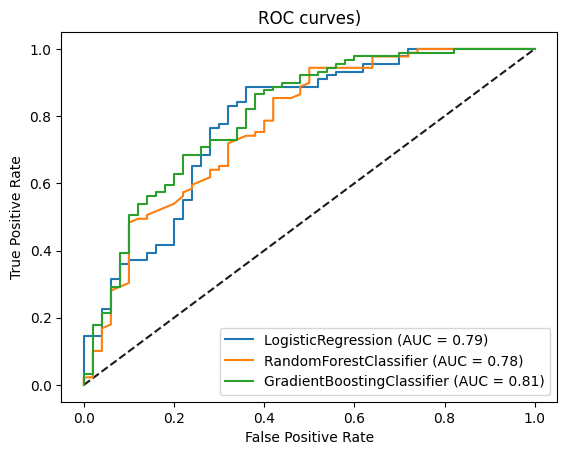

In [95]:
models = [lr_pipe ,rf_pipe, gbm_pipe]
res = pipeline_score_all(models, y_test, X_test)

In [96]:
res

,model,AUROC,prec,recall,F1,thr
0,LogisticRegression,0.785618,0.814433,0.887640,0.849462,0.456486
1,RandomForestClassifier,0.775506,0.770642,0.943820,0.848485,0.490000
2,GradientBoostingClassifier,0.805169,0.802083,0.865169,0.832432,0.582107


### Confusion matrix for top performing model

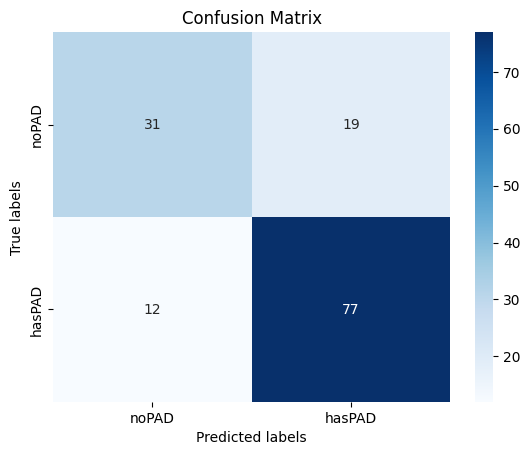

In [109]:
y_pred = (gbm_pipe.predict_proba(X_test)[:,1] >= res["thr"][2]).astype(int)
cm = metrics.confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g',cmap="Blues", ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['noPAD', 'hasPAD']); ax.yaxis.set_ticklabels(['noPAD', 'hasPAD']);

### Best proteins

Now looking at how each predictor (protein and clinical) was contributing to each model's success. The importance measure is scaled to (0,1) for better readability.

In [242]:
feature_names = [re.search("^(.*?)__(.*?)$", x).group(2) for x in lr_pipe[:-1].get_feature_names_out()]

feat_imp = pd.DataFrame({'LR': np.abs(lr_pipe['classifier'].coef_.squeeze()),
"RF": rf_pipe['classifier'].feature_importances_.squeeze(),
"GBM": gbm_pipe['classifier'].feature_importances_.squeeze()}, index= feature_names)

feature_scaler = MinMaxScaler(feature_range=(0,1))
xx = feature_scaler.fit_transform(feat_imp)
xx = pd.DataFrame(xx, columns= feat_imp.keys(), index = feature_names)
xx["sum_importance"] = xx.sum(axis=1)
xx.round(3)

,LR,RF,GBM,sum_importance
uPAR,0.000,0.548,0.133,0.681
SCF,0.060,0.441,0.086,0.587
TSG-14,0.122,0.441,0.080,0.643
RAGE,0.181,0.473,0.120,0.774
ADAMTS13,0.319,0.645,0.325,1.289
Tpo,0.095,0.376,0.034,0.505
TNF RI,0.172,0.492,0.111,0.775
ANGPTL3,0.161,0.648,0.255,1.064
ANGPTL4,0.004,0.508,0.055,0.568
CXCL1,0.326,0.577,0.210,1.113


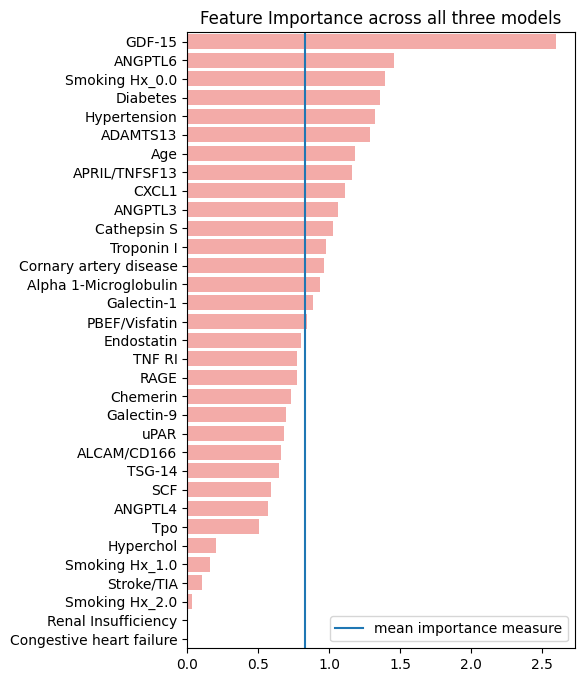

In [243]:
plot_importance(xx["sum_importance"].sort_values(ascending=False), "Feature Importance across all three models")

# Prognostic panel

Predict the occurance of complications in PAD patients

In [337]:
cp = pd.read_excel('./data/pad_complications.xlsx')
cp = cp.merge(df[["ID", "hasPAD"]])
cp = cp.loc[cp.hasPAD == 1]
cp.head()

,ID,Stent,PAD intervention,MI,STROKE,LIMB LOSS,Death,GFR,hasPAD
166,16,L popliteal artery revascularized w/ drug-elut...,"R above knee fempop bypass, redo sx May 11, 2017",0,0,"R 4th + 5th ray amp May 18, 2017",0,>60 (2018),1
167,20,R SFA/pop stent Jan 2020. R SFA + popliteal ar...,R SFA/pop stent Jan 2020. R SFA + popliteal ar...,0,0,"R D1 ray amp, D2, D3 Feb 2019",0,>60,1
168,31,0,0,0,0,0,0,35-45,1
169,38,Balloon angioplasty of L SFA Apr 2019,Balloon angioplasty of L SFA Apr 2019,0,0,0,0,48 (2015),1
170,46,NaN,L fem-pop bypass Sep 2017. R ilio-profunda fem...,0,0,L AKA May 2018. R AKA Dec 2017,0,>60,1


In [338]:
cp.isna().sum().to_frame().rename(columns = {0:"# of missing"})

,# of missing
ID,0
Stent,42
PAD intervention,0
MI,0
STROKE,0
LIMB LOSS,0
Death,0
GFR,10
hasPAD,0


> Variables `GFR` and `Stent` include Null values. GFR needs further information on how to code as outcome

These 5 complications are analysed in the prognostic phase for now:

'PAD intervention', 'MI', 'STROKE', 'LIMB LOSS', 'Death'

In [339]:
cp["c_strk"] = 1
cp.loc[cp['STROKE'] == 0, 'c_strk'] = 0
# print(cp.c_strk.value_counts())

cp["c_death"] = 1
cp.loc[cp['Death'] == 0, 'c_death'] = 0
# print(cp.c_death.value_counts())

cp["c_mi"] = 1
cp.loc[cp['MI'] == 0, 'c_mi'] = 0
# print(cp.c_mi.value_counts())

cp["c_interv"] = 1
cp.loc[cp['PAD intervention'] == 0, 'c_interv'] = 0

cp["c_limbloss"] = 1
cp.loc[cp['LIMB LOSS'] == 0, 'c_limbloss'] = 0

## add new complications

cp["c_mace"] = cp['c_strk'] | cp["c_death"] | cp["c_mi"]
cp["c_male"] = cp['c_interv'] | cp["c_limbloss"]


In [340]:
xx = cp[[col for col in cp.columns if col.startswith("c_")]].apply(pd.value_counts)
xx.loc[xx.shape[0], :] = (xx.iloc[1,:] / xx.iloc[0,:] * 100 ).round(0)
xx.index = [0,1, 'Imbalanced %']
xx.rename_axis("Complications", axis =1 ).rename_axis("info", axis = 0)

Complications,c_strk,c_death,c_mi,c_interv,c_limbloss,c_mace,c_male
info,,,,,,,
0,277.0,288.0,245.0,219.0,277.0,230.0,211.0
1,18.0,7.0,50.0,76.0,18.0,65.0,84.0
Imbalanced %,6.0,2.0,20.0,35.0,6.0,28.0,40.0


> Note: Prediction of each complication in PAD patients, requires a seperate modeling phase. Current features need to be extracted based on their strengths and models need to be seperately tuned and trained for each outcome.

## 1- Stroke

First we start by basic getting the basic statistics with Stroke as a target variable

In [126]:
TARGET = 'c_strk'
newdf = df.loc[df.hasPAD == 1]
newdf = newdf.merge(cp[['ID', TARGET]], how='left', on = 'ID')

In [127]:
table1 = TableOne(newdf, columns=PROTEINS,groupby=TARGET, pval=True)
table1.tableone.style.apply(highlight, axis=1)

In [71]:
table1 = TableOne(newdf, columns=CLINICAL,groupby=TARGET, pval=True, htest_name = True, categorical=CLINICAL[1:])
table1.tableone.style.apply(highlight, axis=1)

Create feature panel for prediction, according to univariate test. There are no significant proteins for Stroke.

In [72]:

final_clinical = [
    'Gender',
    'Hypertension',
    'Hyperchol',
    'Diabetes',
    'Renal Insufficiency',
    'Smoking Hx',
    'Congestive heart failure',
    'Cornary artery disease',
    'Stroke/TIA',
     'statin',
     'ACEi/ARB',
    'B-bl',
     'CCB',
    'HCTZ, Lasix',
    'Insulin'
]

numerical_final = [x for x in PROTEINS if x not in ('TNF RII',  'CD40', 'NT- pro BNP')]
numerical_final.append('Age') if 'Age' not in numerical_final else None
binary_final = [x for x in final_clinical if x not in ('Smoking Hx')]
cat_final = ['Smoking Hx']

# correlation check
# print(get_top_abs_correlations(newdf[final_clinical], 10))
# print(get_top_abs_correlations(newdf[PROTEINS], 10))

# contstructing the preprocessing piplines

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)

binary_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"))

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("onehot", OneHotEncoder(drop=None))]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("continous", numeric_transformer, numerical_final),
        ("binary", binary_transformer, binary_final),
        ("categorical", categorical_transformer, cat_final)
    ]
)


total number of features used as input to pipline = 58
Test AUC Performance on LR = 0.092
Best Threshold=1.991486


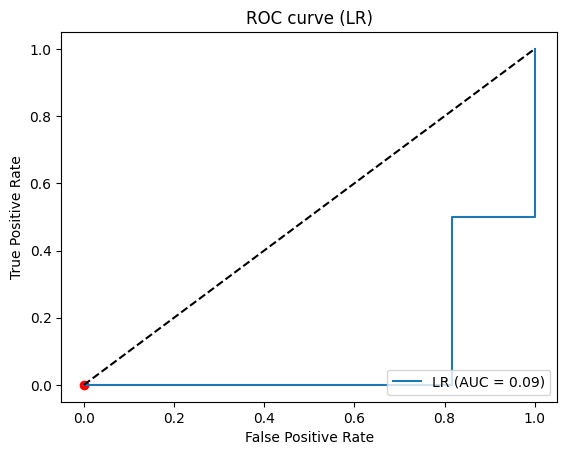

In [73]:
# newX = newdf[numerical_final + binary_final + cat_final].copy()
newX = newdf[numerical_final + binary_final + cat_final].copy()

print(f"total number of features used as input to pipline = {newX.shape[1]}")
y = newdf[TARGET].to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(
    newX, y, stratify= y,
     train_size=0.7, random_state=42)

myModel = LogisticRegressionCV(penalty="l1", solver='liblinear',
                                cv=StratifiedKFold(5),
                                scoring='f1',
                                # class_weight = 'balanced',
                                random_state=42)
model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', myModel)
])

model_pipe.fit(X_train, y_train)
pipeline_score(model_pipe, y_test, X_test, "LR")

In [74]:
y_pred_prob = model_pipe.predict_proba(X_test)[:,1]
# print(f"Test AUC Performance on {clf_name} = {metrics.roc_auc_score(y_test, y_pred_prob):.3f}")
# print(f"Train AUC Performance on {clf_name} = {metrics.roc_auc_score(y_train, pipe.predict_proba(X_train)[:,1]):.3f}")

prec, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_prob)
# get the best threshold - Youan's Index
f1 =  2 * (prec * recall) / (prec + recall)
ix = np.argmax(f1)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.000000


C:\Users\MacREAL3\AppData\Local\Temp\ipykernel_57108\2171912655.py:7: RuntimeWarning: invalid value encountered in divide
  f1 =  2 * (prec * recall) / (prec + recall)


## 2- Death

In [ ]:
TARGET = 'c_death'
newdf = df.loc[df.hasPAD == 1].copy()
newdf = newdf.merge(cp[['ID', TARGET]], how='left', on = 'ID')

In [76]:
table1 = TableOne(newdf, columns=PROTEINS,groupby=TARGET, pval=True)
table1.tableone.style.apply(highlight, axis=1)

In [77]:
table1 = TableOne(newdf, columns=CLINICAL,groupby=TARGET, pval=True, htest_name = True, categorical=CLINICAL[1:])
table1.tableone.style.apply(highlight, axis =1)

## 3- Myocardial Infarction (MI)

In [78]:
TARGET = 'c_mi'
newdf = df.loc[df.hasPAD == 1]
newdf = newdf.merge(cp[['ID', TARGET]], how='left', on = 'ID')

In [81]:
table1 = TableOne(newdf, columns=PROTEINS,groupby=TARGET, pval=True, rename = {'c_mi': 'Myocardial Infarction (MI)'})
table1.tableone.style.apply(highlight, axis=1)

In [82]:
table1 = TableOne(newdf, columns=CLINICAL,groupby=TARGET, pval=True, htest_name = True, categorical=CLINICAL[1:])
table1.tableone.style.apply(highlight, axis=1)

## 4- PAD intervention

In [132]:
TARGET = 'c_interv'
newdf = df.loc[df.hasPAD == 1]
newdf = newdf.merge(cp[['ID', TARGET]], how='left', on = 'ID')

In [133]:
table1_prot = TableOne(newdf, columns=PROTEINS,groupby=TARGET, pval=True)
table1_prot.tableone.style.apply(highlight, axis=1)

In [134]:
table1_clin = TableOne(newdf, columns=CLINICAL,groupby=TARGET, pval=True, htest_name = True, categorical=CLINICAL[1:])
table1_clin.tableone.style.apply(highlight, axis=1)

In [169]:
%%jmd

The highlighted significant predictors are then used in the ML models to predict our outcome __{{TARGET}}__.


The highlighted significant predictors are then used in the ML models to predict our outcome __c_interv__.

In [256]:
# select significant features only
sig_cont = get_sig_from_tableone(table1_prot)
sig_cat = get_sig_from_tableone(table1_clin)

numerical_final = [x for x in sig_cont if x not in ('TNF RII',  'CD40', 'NT- pro BNP')] #drop correlated features
numerical_final.append('Age') if 'Age' not in numerical_final else None
binary_final = [x for x in sig_cat if x not in ('Smoking Hx', 'Age')]
cat_final = ['Smoking Hx']


preprocessor = ColumnTransformer(
    transformers=[
        ("continous", numeric_transformer, numerical_final),
        ("binary", binary_transformer, binary_final),
        ("categorical", categorical_transformer, cat_final)
    ]
)

newX = newdf[numerical_final + binary_final + cat_final].copy()

print(f"total number of features used as input to pipline = {newX.shape[1]}")
y = newdf[TARGET].to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(
    newX, y, stratify= y,
     train_size=0.7, random_state=42)

myModel = LogisticRegressionCV(penalty="l1", solver='liblinear',
                                cv=StratifiedKFold(5),
                                scoring='f1',
                                # class_weight = 'balanced',
                                random_state=42)
model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', myModel)
])

model_pipe.fit(X_train, y_train)

## create a dictinary for all trained piplines
from collections import defaultdict
trained_pipelines = defaultdict(list)
trained_pipelines[TARGET].append(model_pipe)

# pipeline_score(model_pipe, y_test, X_test, "LR")

total number of features used as input to pipline = 17


In [257]:
mod_rf = RandomForestClassifier(n_estimators=30, max_depth=4)

model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', mod_rf)
])

param_grid = {
    'classifier__n_estimators': [10, 20, 30, 40, 50],
    'classifier__max_depth': [2,3,4,5,6],
    'classifier__max_features': [None, 'sqrt', 'log2', 0.3, 0.4, 0.5],
    'classifier__min_samples_split': [2,4,8,16,32]
}

search = GridSearchCV(model_pipe,
                      param_grid,
                      cv=StratifiedKFold(5),
                      n_jobs=-1,
                      scoring="f1",
                      return_train_score=True)
search.fit(X_train, y_train)

tuned_params = search.best_estimator_['classifier'].get_params()
mod_rf = RandomForestClassifier(**tuned_params)

model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', mod_rf)
])

model_pipe.fit(X_train, y_train)
trained_pipelines[TARGET].append(model_pipe)



In [259]:
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)

model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', brf)
])

model_pipe.fit(X_train, y_train)
trained_pipelines[TARGET].append(model_pipe)


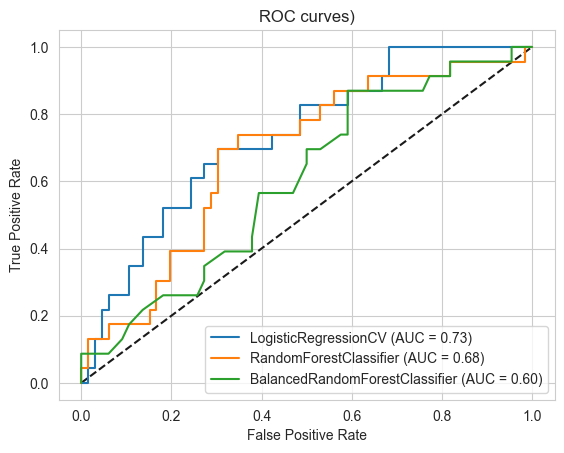

,model,AUROC,prec,recall,F1,thr
0,LogisticRegressionCV,0.732543,0.444444,0.695652,0.542373,0.237189
1,RandomForestClassifier,0.680501,0.444444,0.695652,0.542373,0.253835
2,BalancedRandomForestClassifier,0.601779,0.338983,0.869565,0.487805,0.390000


In [261]:
pipeline_score_all(trained_pipelines[TARGET], y_test, X_test)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


Text(0.5, 1.0, 'Scoring for different class weights')

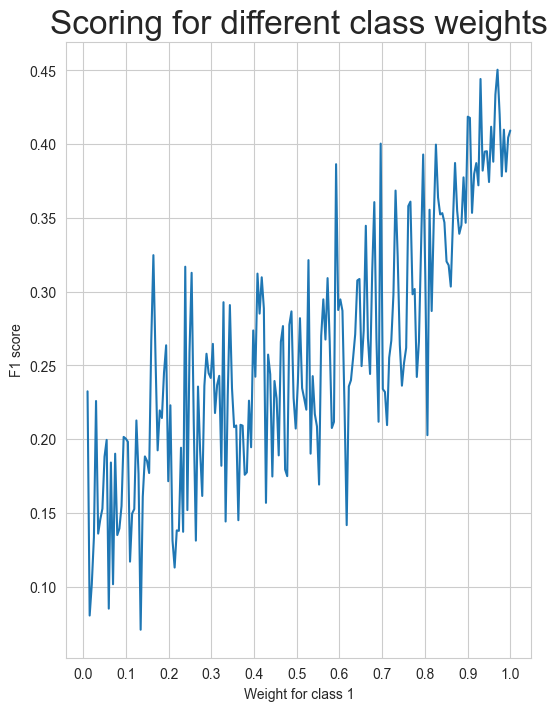

In [252]:
#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'classifier__class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= model_pipe, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(5), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2)

gridsearch.fit(X_train, y_train)
#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(6,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(x = weigh_data['weight'], y = weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)
plt.plot()

In [228]:
### hyper parameter tuning for GBM

param_grid_1 = {
    'max_depth': range(3,10),
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2],
    'subsample': [0.7, 0.8, 0.9, 1] #stochastic gradient boosting
}
param_grid = {f"classifier__{k}":v for k,v in param_grid_1.items()}

clf = GradientBoostingClassifier(loss='log_loss', random_state=42 )
model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', clf)
])

search = RandomizedSearchCV(model_pipe, param_grid, cv=StratifiedKFold(
    5), n_iter=100, scoring="f1", random_state=42, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter - first tuning (CV score(f1)=%0.3f):" % search.best_score_)
print(search.best_params_)

#####

tuned_params_1 = search.best_estimator_['classifier'].get_params()
clf = GradientBoostingClassifier(**tuned_params_1)

param_grid_2 = {
    'max_features' : [None, 'sqrt', 'log2', 0.3, 0.4, 0.5, 0.6],
    'min_samples_split': [2,4,8,16,32,64],
    "min_samples_leaf": [1, 2, 5, 10, 20, 50, 100],
    'criterion': ['friedman_mse', 'squared_error'],
    
}
param_grid = {f"classifier__{k}":v for k,v in param_grid_2.items()}

model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', clf)
])

search = RandomizedSearchCV(model_pipe, param_grid, cv= StratifiedKFold(5), n_iter = 100, scoring="f1", random_state=42, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter - second tuning (CV score(f1)=%0.3f):" % search.best_score_)
print(search.best_params_)

######

tuned_params_2 = search.best_estimator_['classifier'].get_params()
clf = GradientBoostingClassifier(**tuned_params_2)

param_grid = {
    'classifier__ccp_alpha': np.linspace(0, 0.01, 50)
}

model_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', clf)
])

search = GridSearchCV(model_pipe, param_grid, cv= StratifiedKFold(5), n_jobs=-1, scoring="f1", return_train_score=True)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter - first tuning (CV score(f1)=0.369):
{'classifier__subsample': 0.8, 'classifier__n_estimators': 50, 'classifier__max_depth': 8, 'classifier__learning_rate': 1}
Best parameter - second tuning (CV score(f1)=0.387):
{'classifier__min_samples_split': 32, 'classifier__min_samples_leaf': 20, 'classifier__max_features': 0.6, 'classifier__criterion': 'friedman_mse'}
Best parameter (CV score=0.412):
{'classifier__ccp_alpha': 0.007346938775510205}


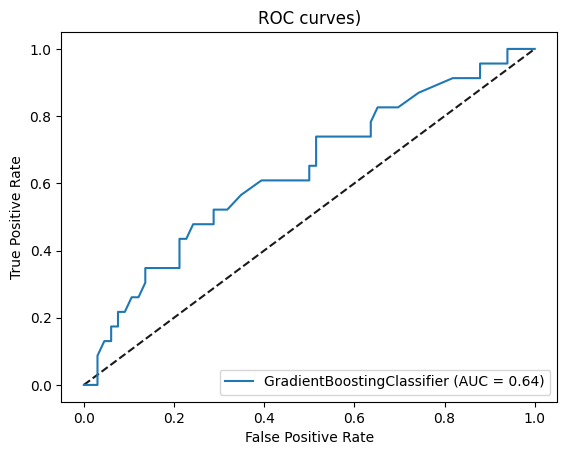

,model,AUROC,prec,recall,F1,thr
0,GradientBoostingClassifier,0.635705,0.407407,0.478261,0.44,0.236548


In [231]:
final_tuned = search.best_estimator_['classifier'].get_params()
clf = GradientBoostingClassifier(**final_tuned)
gbm_pipe = Pipeline([
    ("preprocessing", preprocessor),
    ('classifier', clf)
])

gbm_pipe.fit(X_train, y_train)
trained_pipelines[TARGET] += [gbm_pipe]

pipeline_score_all([gbm_pipe], y_test, X_test)

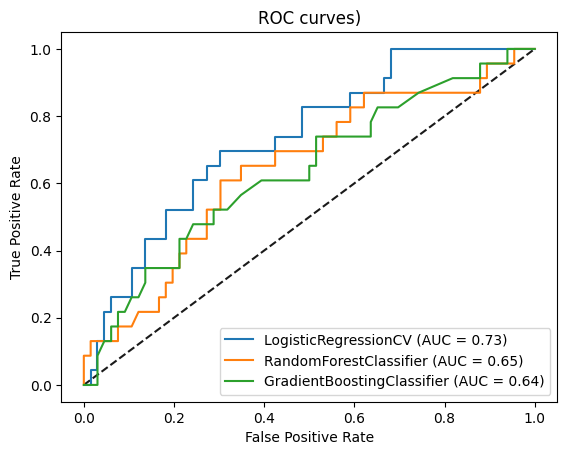

,model,AUROC,prec,recall,F1,thr
0,LogisticRegressionCV,0.732543,0.444444,0.695652,0.542373,0.237189
1,RandomForestClassifier,0.645916,0.411765,0.608696,0.491228,0.250000
2,GradientBoostingClassifier,0.635705,0.407407,0.478261,0.440000,0.236548


In [233]:
pipeline_score_all(trained_pipelines[TARGET],y_test, X_test)

## 5- Limb Loss

In [86]:
TARGET = 'c_limbloss'
newdf = df.loc[df.hasPAD == 1]
newdf = newdf.merge(cp[['ID', TARGET]], how='left', on = 'ID')

In [87]:
table1 = TableOne(newdf, columns=PROTEINS,groupby=TARGET, pval=True)
table1.tableone.style.apply(highlight, axis=1)

In [88]:
table1 = TableOne(newdf, columns=CLINICAL,groupby=TARGET, pval=True, htest_name = True, categorical=CLINICAL[1:])
table1.tableone.style.apply(highlight, axis=1)

In [ ]:
# add MACE AND MALE Analysis as well

## 6- MACE - major adverse cardiovascular events

In [341]:
TARGET = 'c_mace'
newdf = df.loc[df.hasPAD == 1]
newdf = newdf.merge(cp[['ID', TARGET]], how='left', on = 'ID')
table1_prot = TableOne(newdf, columns=PROTEINS,groupby=TARGET, pval=True)
table1_prot.tableone.style.apply(highlight, axis=1)


In [342]:
table1_clin = TableOne(newdf, columns=CLINICAL,groupby=TARGET, pval=True, htest_name = True, categorical=CLINICAL[1:])
table1_clin.tableone.style.apply(highlight, axis=1)

# Appendix

### Exploring the warning raised by Hartigan's Dip Test

In [22]:
df[["KIM-1", "BMP-2", "CXCL1", "PBEF/Visfatin"]].describe().round(2)

,KIM-1,BMP-2,CXCL1,PBEF/Visfatin
count,461.00,461.00,443.00,444.00
mean,100.45,40.65,237.50,24587.49
std,80.77,18.63,152.28,57667.35
min,16.99,6.19,4.09,83.19
25%,51.97,27.94,159.98,5838.81
50%,78.22,45.50,217.60,10283.50
75%,124.44,52.39,269.66,17858.68
max,855.40,259.94,2060.37,548781.55


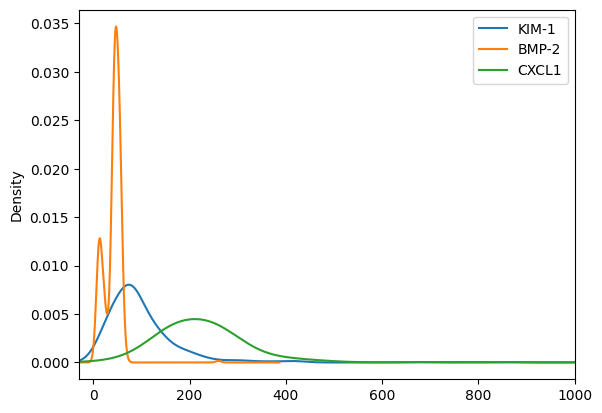

In [23]:
df[["KIM-1", "BMP-2", "CXCL1"]].dropna().plot.kde()
plt.xlim([-30, 1000])
plt.show()

> Protein BMP-2 appears to have a bimodal distribution (non-normality)

<AxesSubplot: ylabel='Density'>

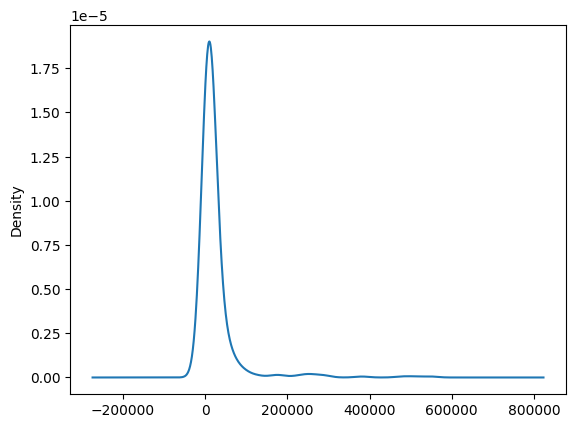

In [24]:
df["PBEF/Visfatin"].dropna().plot.kde()
## possibly outliers

In [25]:
### Trying on a smaller subset of proteins

In [117]:
## proteins with significant anova test from prev file

num_feat_selected = ['uPAR', 'SCF', 'TSG-14', 'RAGE', 'ADAMTS13', 'Tpo', 'TNF RII', 'TNF RI',
       'ANGPTL3', 'ANGPTL4', 'CD40', 'CXCL1', 'NT- pro BNP', 'Troponin I',
       'ANGPTL6', 'Alpha 1-Microglobulin', 'Galectin-9', 'PBEF/Visfatin',
       'Cathepsin S', 'APRIL/TNFSF13', 'Galectin-1', 'ALCAM/CD166', 'GDF-15',
       'Chemerin', 'Endostatin', 'Age']

table2 = TableOne(df_viz, columns = num_feat_selected,  dip_test=True, normal_test=True, tukey_test=True)
table2

,,Missing,Overall
n,,,461
"uPAR, mean (SD)",,15,1910.5 (959.5)
"SCF, mean (SD)",,15,111.9 (49.0)
"TSG-14, mean (SD)",,14,1324.6 (636.0)
"RAGE, mean (SD)",,7,2461.3 (1462.5)
"ADAMTS13, mean (SD)",,12,1077422.7 (501757.5)
"Tpo, mean (SD)",,9,1544.8 (755.4)
"TNF RII, mean (SD)",,13,3119.0 (2191.3)
"TNF RI, mean (SD)",,0,1785.6 (1337.7)
"ANGPTL3, mean (SD)",,0,47866.8 (22404.5)


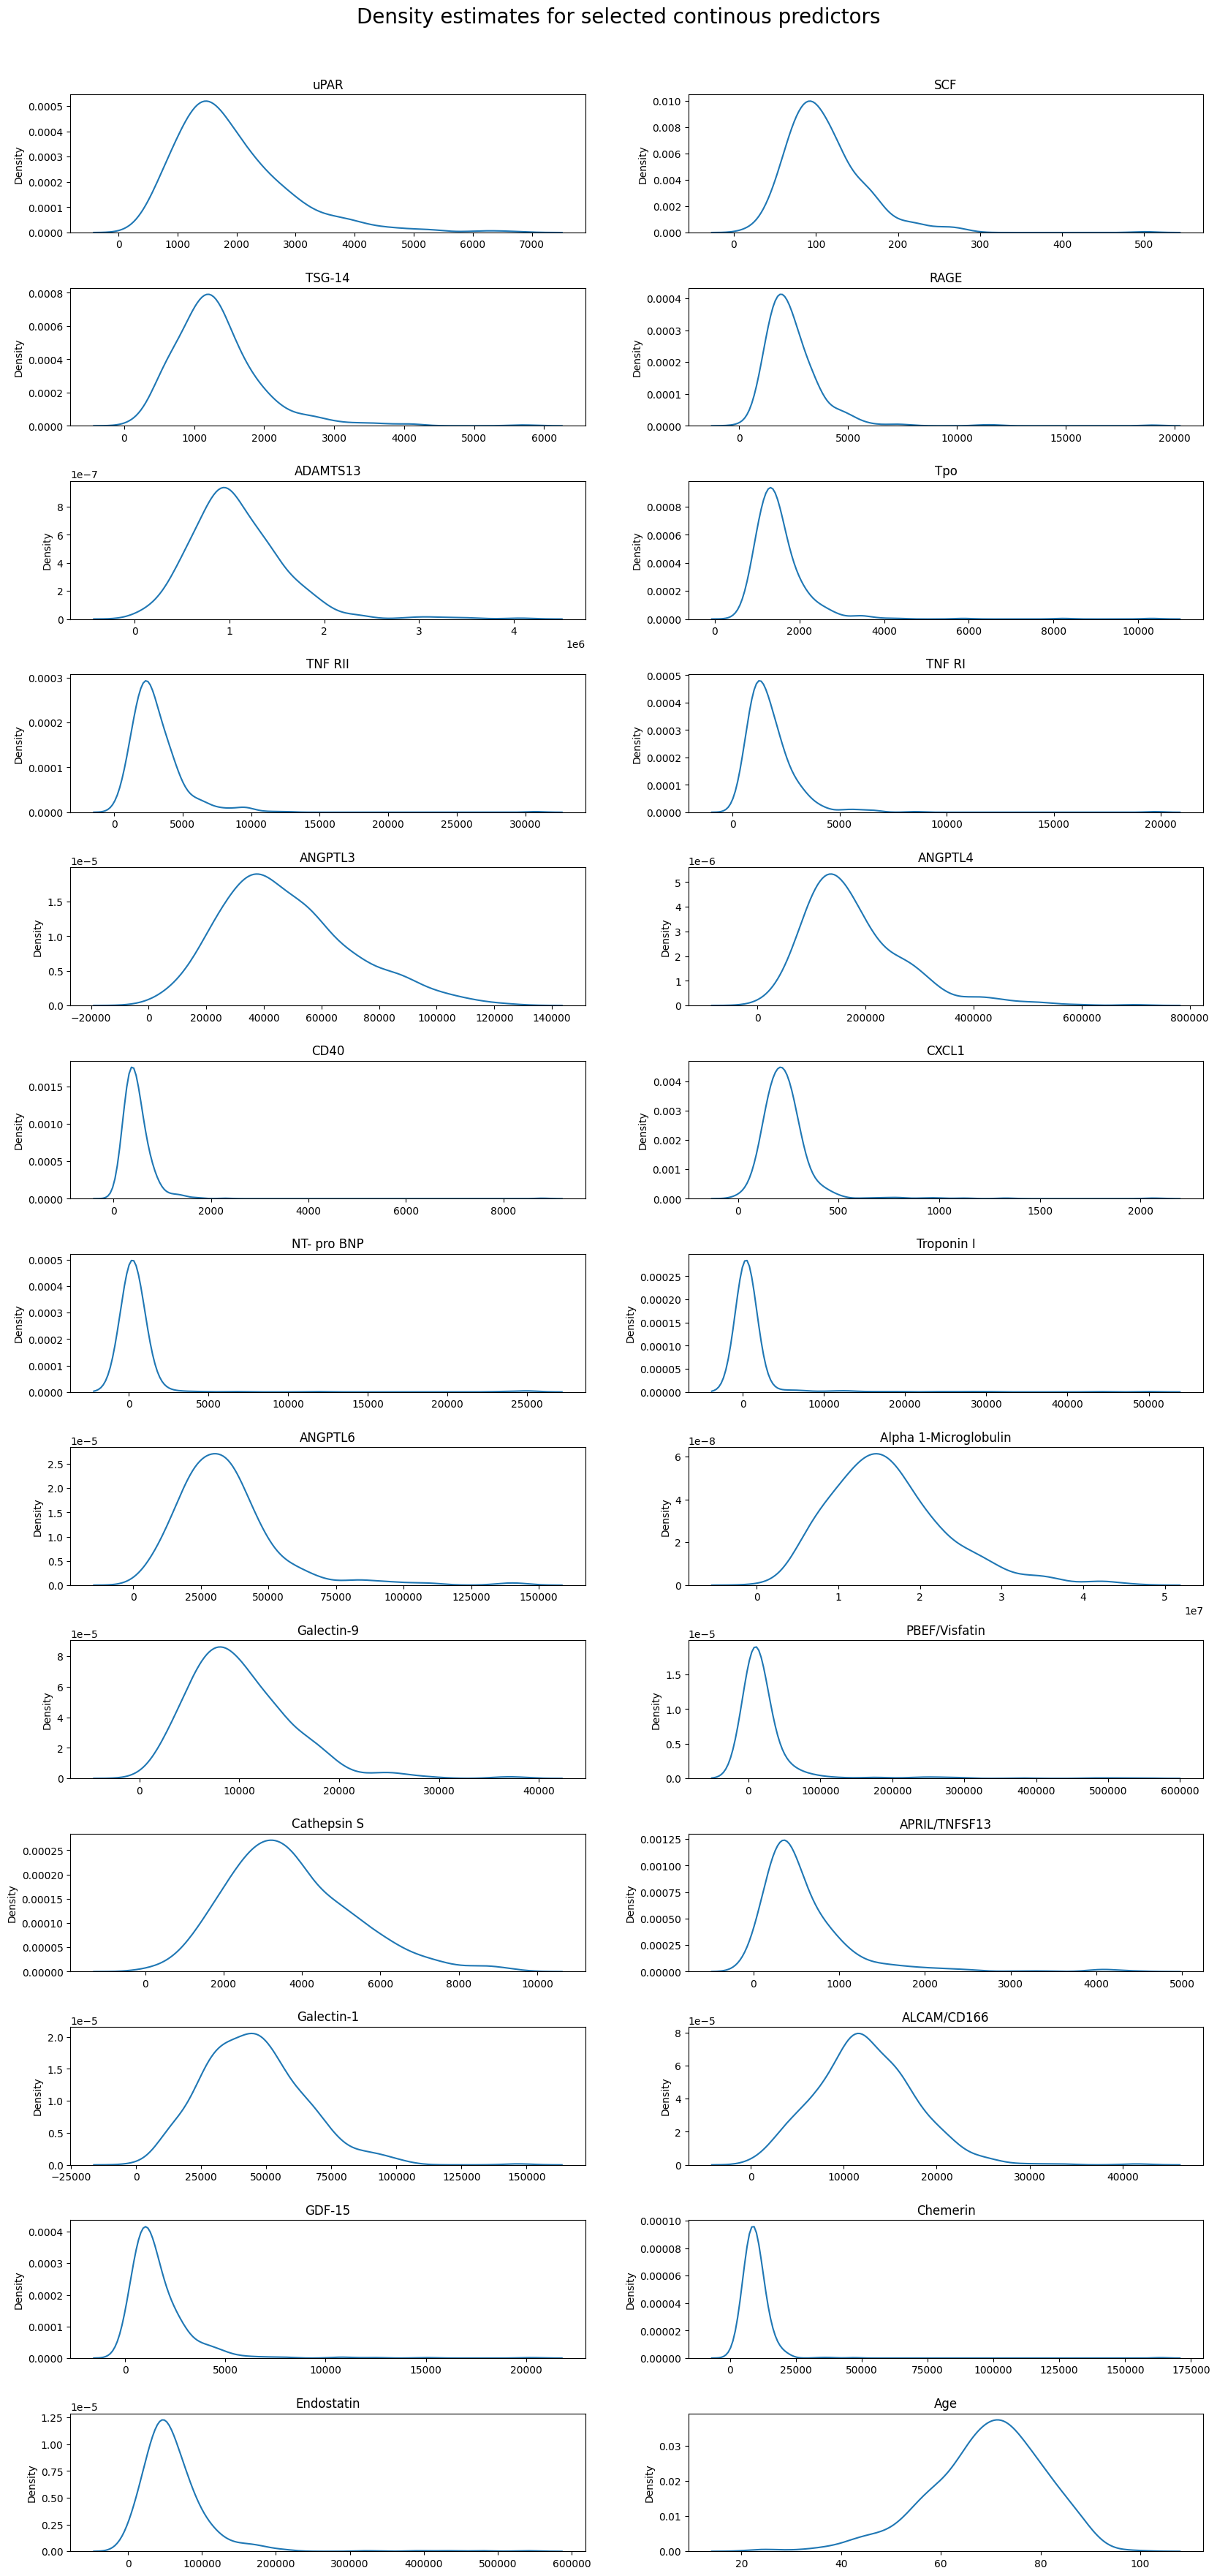

In [27]:
n = len(num_feat_selected)
fig, axs = plt.subplots(nrows = n//2, ncols = 2, figsize = (20,40))
fig.subplots_adjust(hspace=.4, top = .95) #space between subplots
fig.suptitle("Density estimates for selected continous predictors",size=20)
for col, ax in zip(num_feat_selected, axs.ravel()):
    g = sns.kdeplot(df[col], ax= ax)
    g.set_title(str(col))
    g.set_xlabel("")
plt.show()

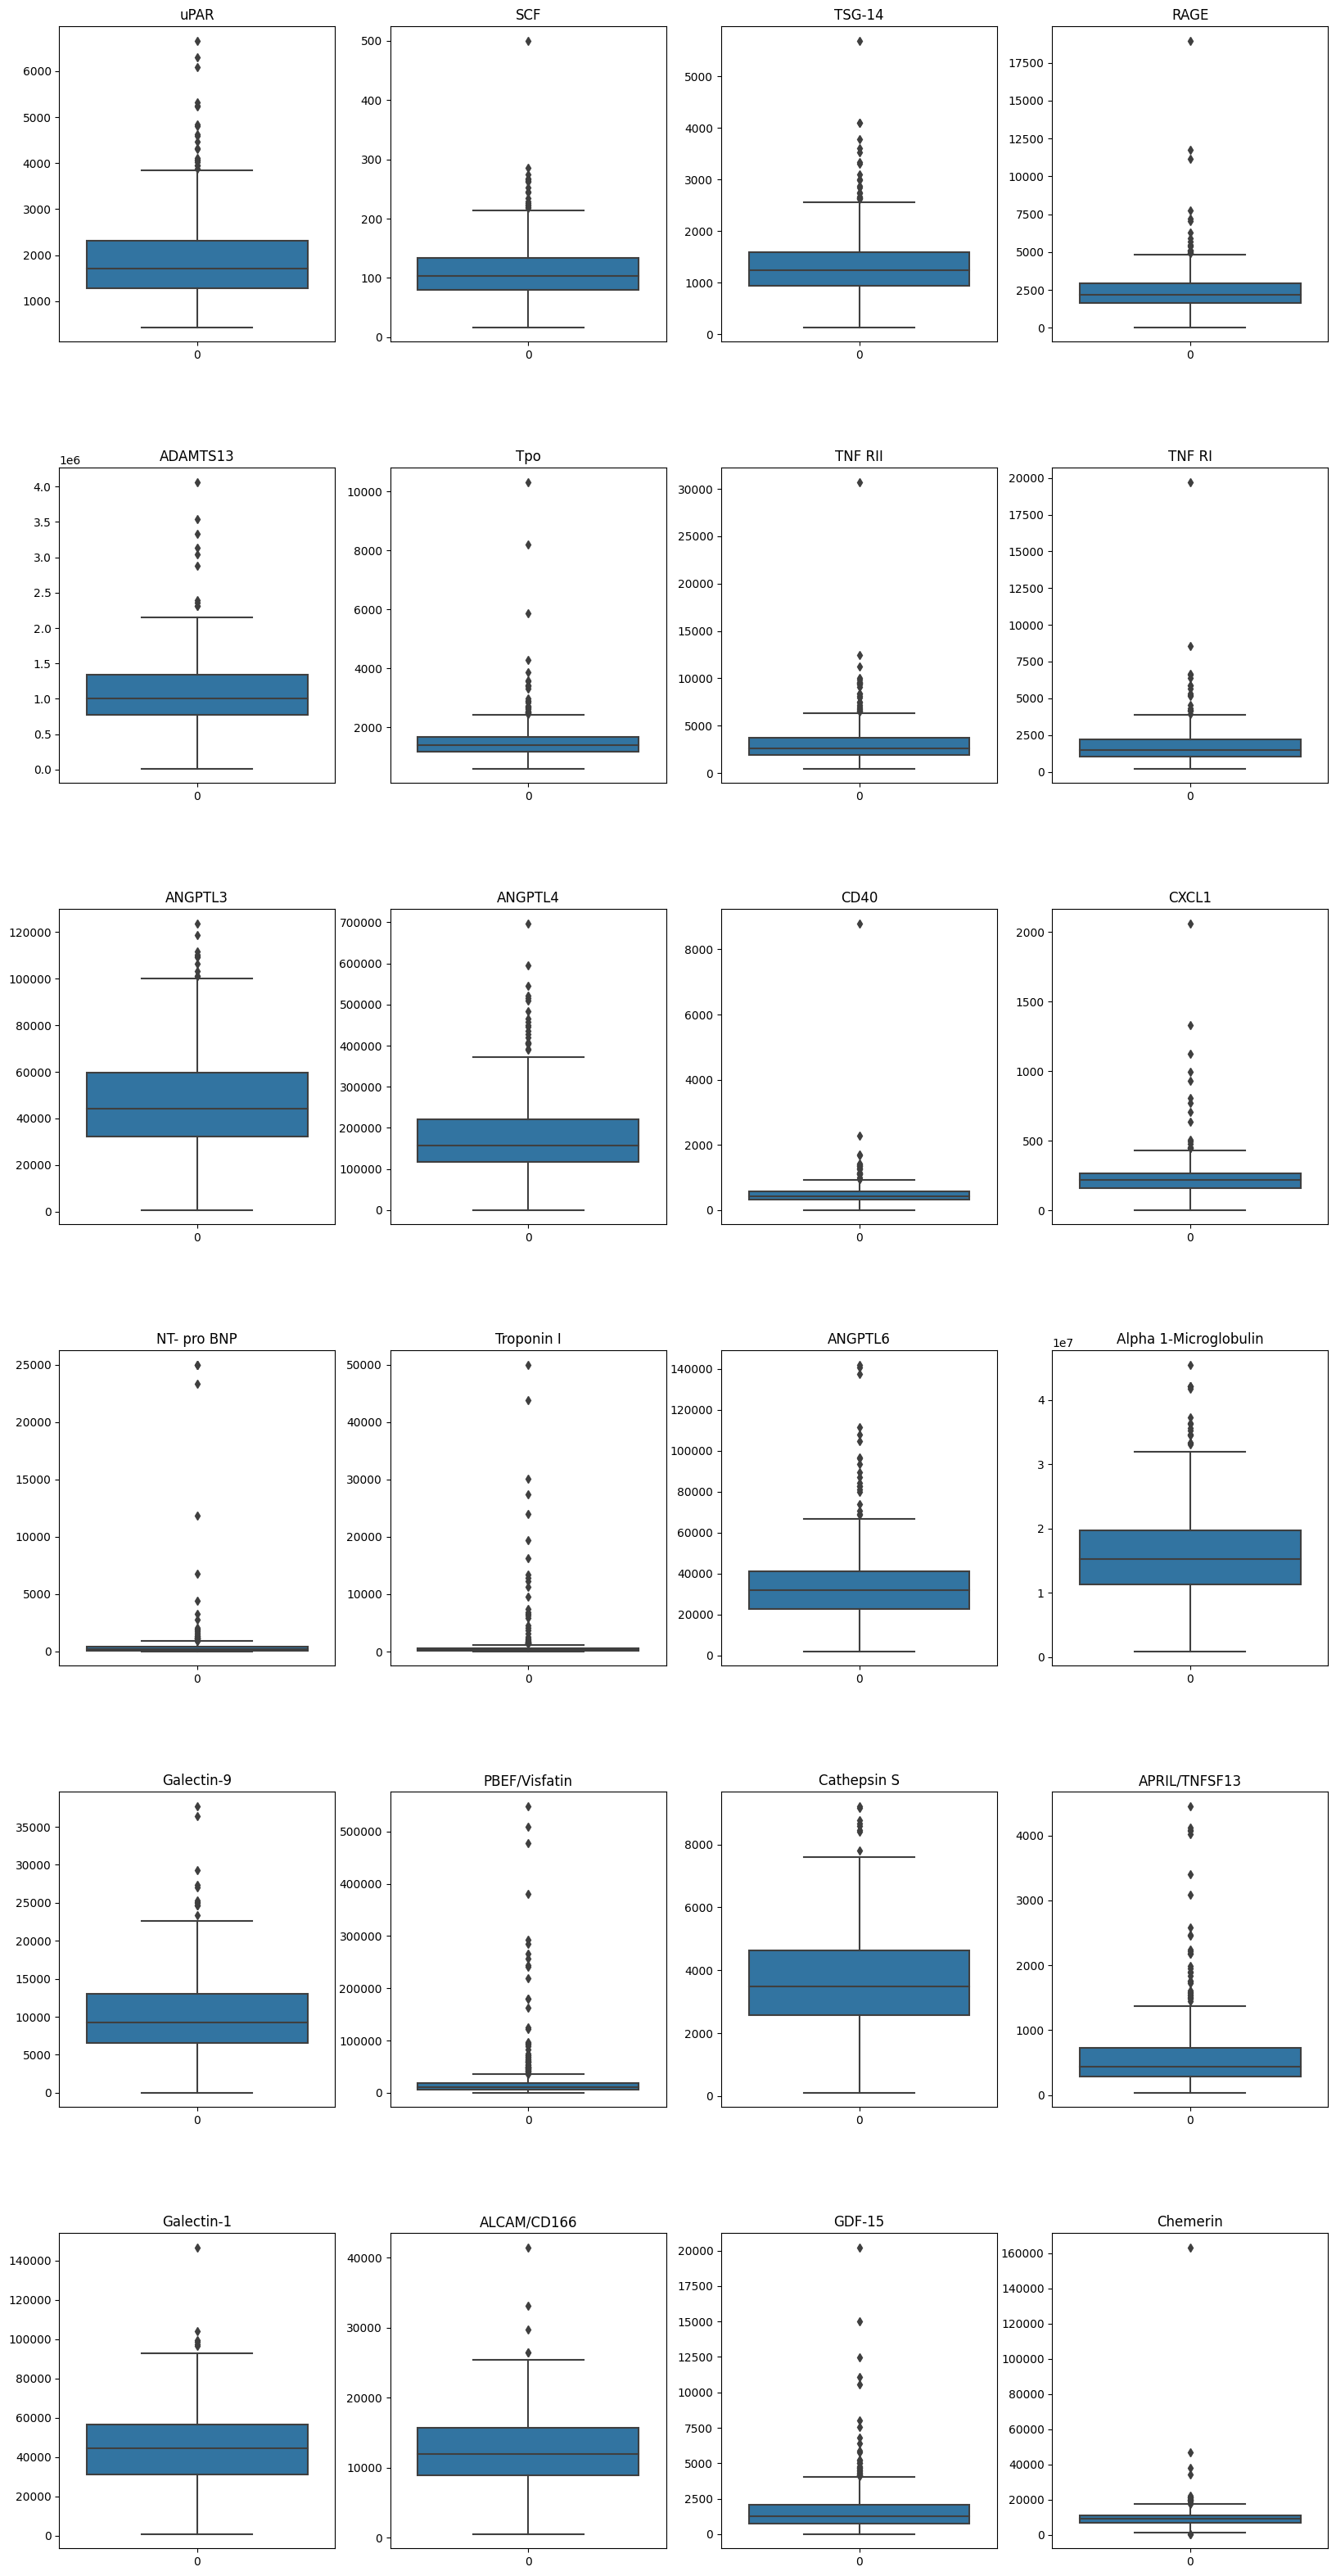

In [28]:
##outlier analysis

n = len(num_feat_selected)
fig, axs = plt.subplots(nrows = n//4, ncols = 4, figsize = (20,40))
plt.subplots_adjust(hspace=.4) #space between subplots
plt.title = "Box plot for selected proteins - outlier analysis"
for col, ax in zip(num_feat_selected, axs.ravel()):
    g = sns.boxplot(df[col], ax= ax)
    g.set_title(str(col))
    g.set_xlabel("")
plt.show()

## Comment about FABP3

The data shows no major difference between patient groups regarding this protein.

In [118]:
df[["FABP3 1value (pg/ml) baseline", "FABP4"]]
TableOne(df_viz, columns=["FABP3 1value (pg/ml) baseline", "FABP4"], groupby="hasPAD",  pval = True,
                  htest_name=True)

Grouped by hasPAD                                                                                    
                                                    Missing            Overall           With PAD        Without PAD P-Value               Test
n                                                                          461                295                166                           
FABP3 1value (pg/ml) baseline, mean (SD)                 36    3962.5 (2142.5)    3849.7 (2259.3)    4149.2 (1926.1)   0.147  Two Sample T-test
FABP4, mean (SD)                                         59  23640.7 (35467.4)  22309.4 (39661.2)  26187.4 (25540.6)   0.236  Two Sample T-test

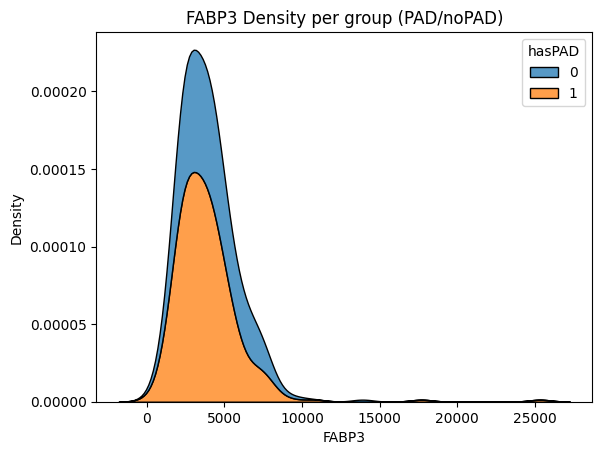

In [6]:
g = sns.kdeplot(df, x = "FABP3 1value (pg/ml) baseline", hue = "hasPAD", multiple="stack")
g.set_xlabel("FABP3")
g.set_title("FABP3 Density per group (PAD/noPAD)")
plt.show()